<a href="https://colab.research.google.com/github/lukiod/dl-college/blob/main/ProgrammingAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Image Classification: Comparing MLP vs CNN
# CSE4007 - Programming Assignment 1

# Import necessary libraries


---


Name  ->Mohak Gupta

Class -> CSE4

Enrollment_NO ->220438

##unziping data

In [ ]:
!unrar x '/content/dataset.rar'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/dataset.rar


Would you like to replace the existing file dataset/images/image_crocus_0001.png
690513 bytes, modified on 2015-06-06 08:30
with a new one
690513 bytes, modified on 2015-06-06 08:30

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


## 1. Problem Statement and Expected Outcome

"""
Multi-Class Image Classification: Comparing the Performance of a Feed-Forward
Neural Network (MLP) versus a Convolutional Neural Network (CNN).

Compare two deep learning approaches for an image classification task focused on
identifying flower types. You will build and evaluate a Feed-Forward Neural Network
(Multi-Layer Perceptron, or MLP) and a Convolutional Neural Network (CNN) using the
same dataset.

For the MLP approach:
- Preprocess data by applying binary masks to original images
- Extract features (color histograms) focusing on flower regions
- Train MLP on extracted features

For the CNN approach:
- Use raw images directly as inputs
- Let network learn relevant features automatically

The goal is to compare performance considering:
- Computational efficiency
- Model accuracy
- Effectiveness of feature representation
"""

## EDA On the Data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Define paths
DATASET_PATH = '/content/dataset/'
IMAGES_PATH = os.path.join(DATASET_PATH, 'images')
MASKS_PATH = os.path.join(DATASET_PATH, 'masks')

### Data Exploration

In [ ]:
# Check how many files we have
print(f"Images directory contains: {len(os.listdir(IMAGES_PATH))} files")
print(f"Masks directory contains: {len(os.listdir(MASKS_PATH))} files")


Images directory contains: 234 files
Masks directory contains: 234 files


In [ ]:
print("\nSample image filenames:")
for filename in list(os.listdir(IMAGES_PATH))[:3]:
    print(f"  {filename}")

print("\nSample mask filenames:")
for filename in list(os.listdir(MASKS_PATH))[:3]:
    print(f"  {filename}")


Sample image filenames:
  image_daisy_0134.png
  image_daisy_0133.png
  image_sunflower_0097.png

Sample mask filenames:
  mask_sunflower_0075.png
  mask_crocus_0038.png
  mask_pansy_0198.png


In [ ]:
classes = set()
for filename in os.listdir(IMAGES_PATH):
    parts = filename.split('_')
    if len(parts) >= 3:
        class_name = parts[1]  # Class name is in the middle (image_CLASS_NUMBER.png)
        classes.add(class_name)
print(f"\nFound {len(classes)} flower classes: {', '.join(classes)}")


Found 4 flower classes: crocus, daisy, pansy, sunflower


In [ ]:
# Count images per class
class_counts = {}
for filename in os.listdir(IMAGES_PATH):
    parts = filename.split('_')
    if len(parts) >= 3:
        class_name = parts[1]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

print("\nImages per class:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count}")



Images per class:
  daisy: 57
  sunflower: 71
  pansy: 56
  crocus: 50


This shows dataset has mild imbalance, but manageable with augmentation and regularization.

###Visualize Images

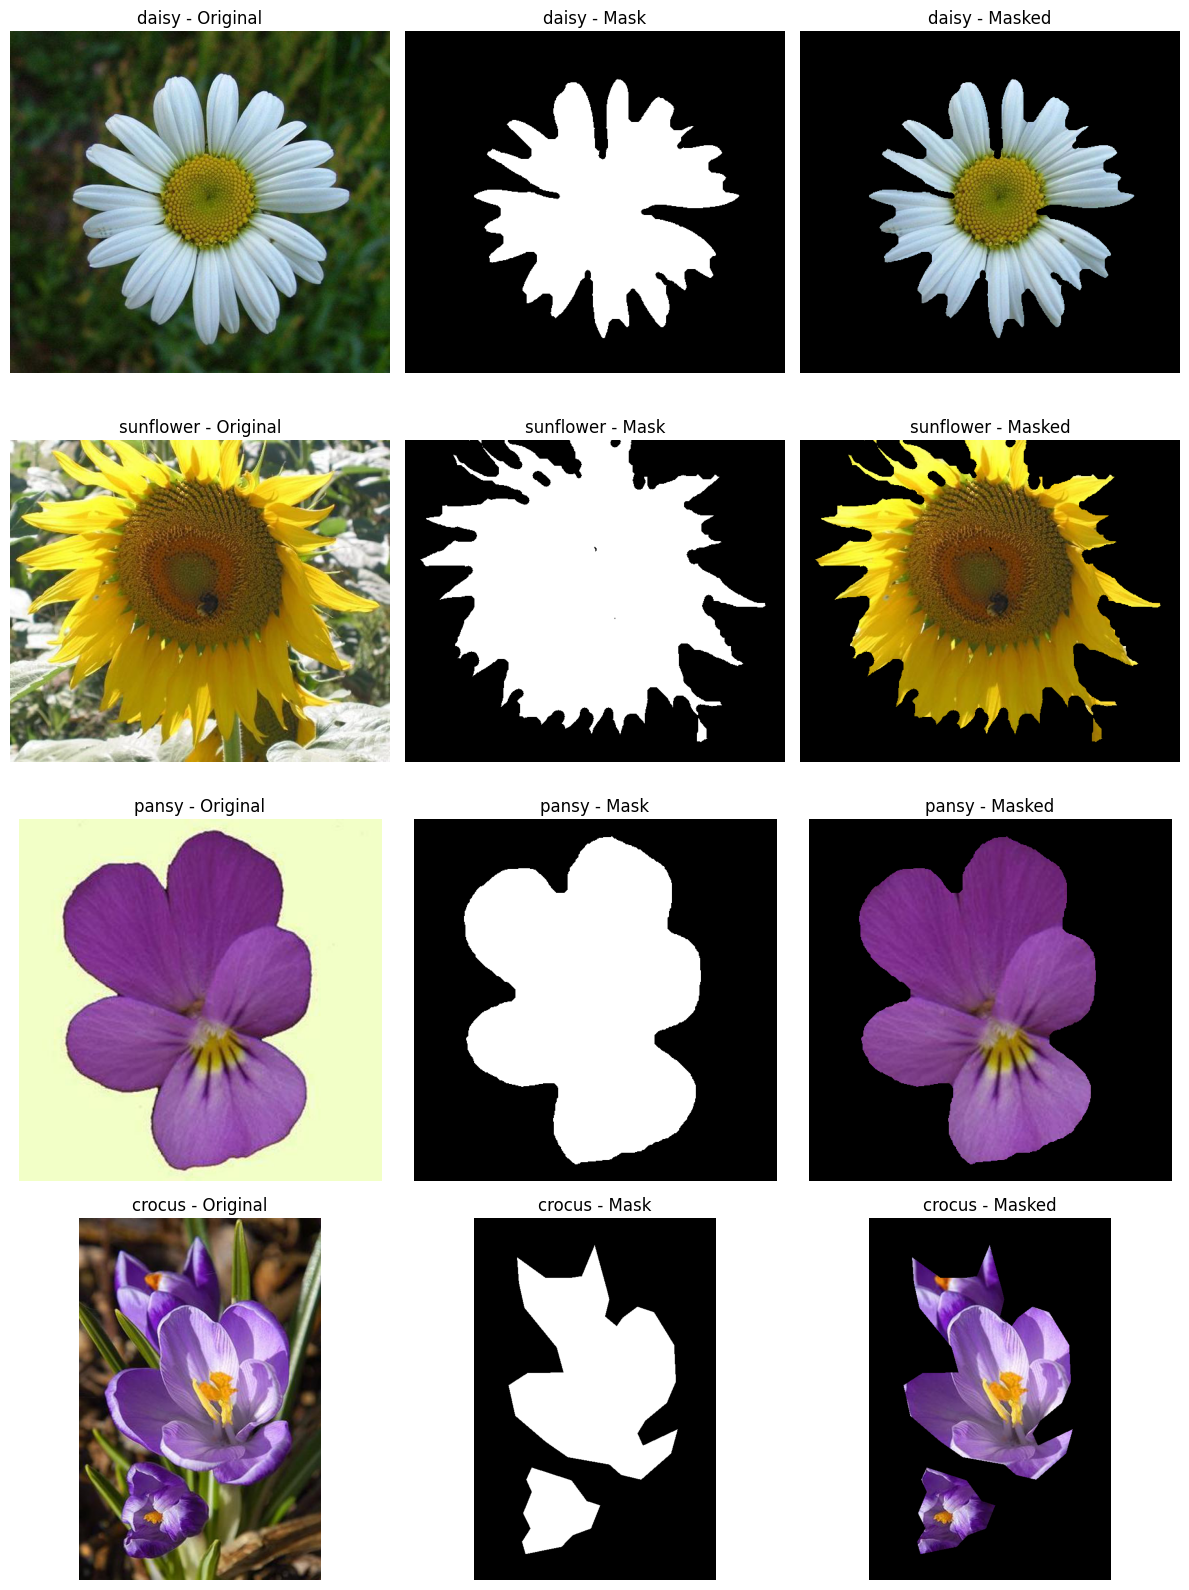

In [ ]:
class_samples = {}
for img_file in os.listdir(IMAGES_PATH):
    parts = img_file.split('_')
    if len(parts) >= 3:
        class_name = parts[1]
        if class_name not in class_samples:
            class_samples[class_name] = img_file

# Display images and masks
fig, axes = plt.subplots(len(class_samples), 3, figsize=(12, 4*len(class_samples)))

for i, (class_name, img_file) in enumerate(class_samples.items()):
    # Create mask filename from image filename
    mask_file = img_file.replace("image", "mask")

    # Load original image
    img_path = os.path.join(IMAGES_PATH, img_file)
    img = Image.open(img_path)

    # Load mask
    mask_path = os.path.join(MASKS_PATH, mask_file)
    mask = Image.open(mask_path).convert('L')

    # Apply mask to image
    img_array = np.array(img)
    mask_array = np.array(mask) / 255.0

    # Resize mask if dimensions don't match
    if img_array.shape[:2] != mask_array.shape:
        mask_array = cv2.resize(mask_array, (img_array.shape[1], img_array.shape[0]))

    # Apply mask
    masked_img = img_array.copy()
    for c in range(3):  # Apply mask to each channel
        masked_img[:,:,c] = img_array[:,:,c] * mask_array
    masked_img = masked_img.astype(np.uint8)

    # Display
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'{class_name} - Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'{class_name} - Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(masked_img)
    axes[i, 2].set_title(f'{class_name} - Masked')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

Testing as to images and mask are read properly by displaying mask and image and than an overlay of it

###Image Properties

In [ ]:
image_files = os.listdir(IMAGES_PATH)
sample_size = 20
sampled_files = random.sample(image_files, min(sample_size, len(image_files)))

# Initialize lists to store properties
widths = []
heights = []
aspect_ratios = []
for img_file in sampled_files:
    img_path = os.path.join(IMAGES_PATH, img_file)
    img = Image.open(img_path)
    width, height = img.size

    widths.append(width)
    heights.append(height)
    aspect_ratios.append(width / height)

# Display statistics
print("Image Dimensions (based on sample):")
print(f"Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
print(f"Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
print(f"Aspect Ratio: min={min(aspect_ratios):.2f}, max={max(aspect_ratios):.2f}, mean={np.mean(aspect_ratios):.2f}")


Image Dimensions (based on sample):
Width: min=500, max=769, mean=575.1
Height: min=499, max=668, mean=547.4
Aspect Ratio: min=0.75, max=1.54, mean=1.08


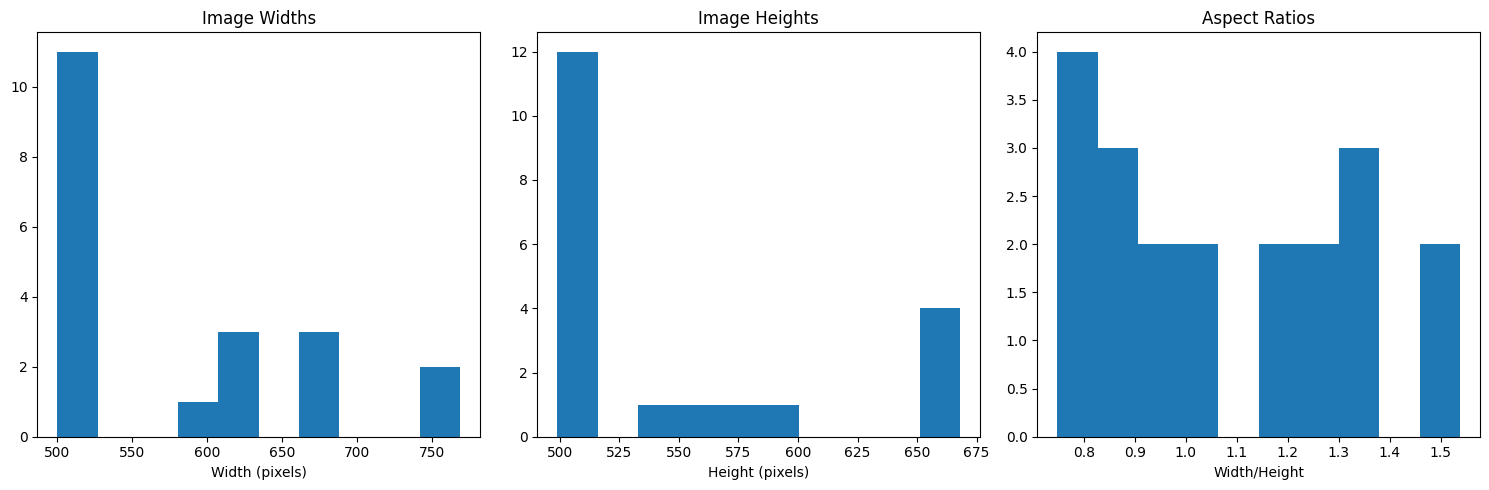

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(widths, bins=10)
plt.title('Image Widths')
plt.xlabel('Width (pixels)')

plt.subplot(1, 3, 2)
plt.hist(heights, bins=10)
plt.title('Image Heights')
plt.xlabel('Height (pixels)')

plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=10)
plt.title('Aspect Ratios')
plt.xlabel('Width/Height')

plt.tight_layout()
plt.show()

finding out at which size image resizing is possible so as while resizing image dimension doesnt get lost and came to a conlusion as to use 256x256 since we have less less number of images and i dont want my model to overfit

Analyzing histograms for image: image_daisy_0178.png (class: daisy)


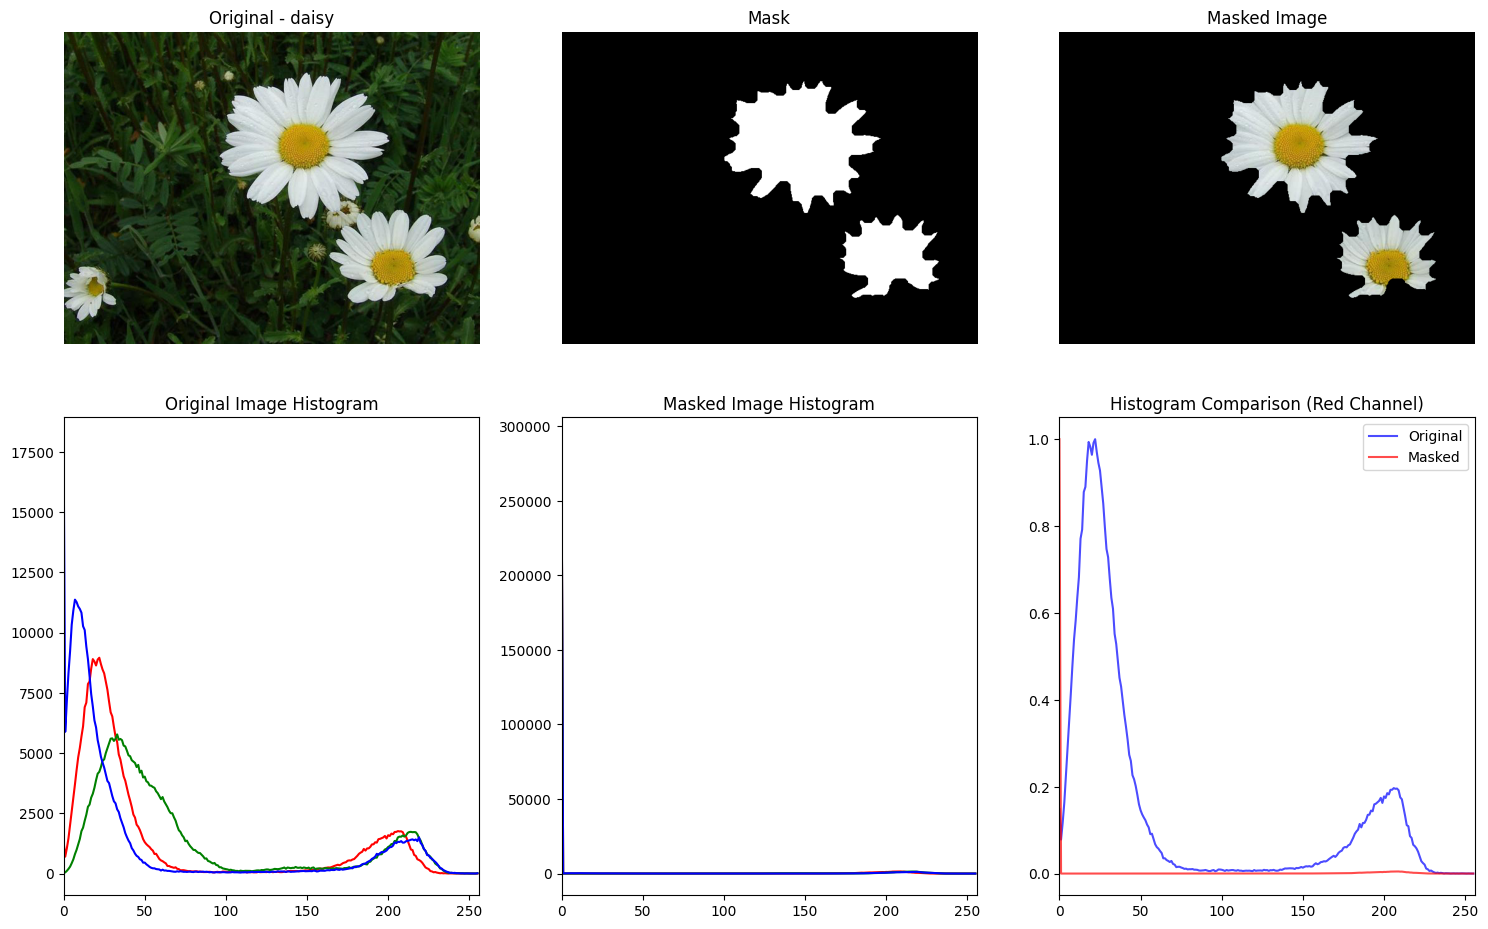

In [ ]:
# Get a random image
img_file = random.choice(image_files)
parts = img_file.split('_')
if len(parts) >= 3:
    class_name = parts[1]
else:
    class_name = "unknown"

# Construct mask filename
mask_file = img_file.replace("image", "mask")

# Load image and mask
img_path = os.path.join(IMAGES_PATH, img_file)
mask_path = os.path.join(MASKS_PATH, mask_file)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Resize mask if needed
if img.shape[:2] != mask.shape:
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

# Apply mask
masked_img = img.copy()
for c in range(3):
    masked_img[:,:,c] = masked_img[:,:,c] * (mask / 255.0)

print(f"Analyzing histograms for image: {img_file} (class: {class_name})")
plt.figure(figsize=(15, 10))

# Images
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title(f'Original - {class_name}')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(masked_img)
plt.title('Masked Image')
plt.axis('off')

# Histograms
colors = ('r', 'g', 'b')

plt.subplot(2, 3, 4)
for i, color in enumerate(colors):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
plt.title('Original Image Histogram')
plt.xlim([0, 256])

plt.subplot(2, 3, 5)
for i, color in enumerate(colors):
    hist = cv2.calcHist([masked_img], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
plt.title('Masked Image Histogram')
plt.xlim([0, 256])

# Show difference in histograms
plt.subplot(2, 3, 6)
# Get histograms for red channel as an example
orig_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
mask_hist = cv2.calcHist([masked_img], [0], None, [256], [0, 256])

# Normalize for comparison
cv2.normalize(orig_hist, orig_hist, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(mask_hist, mask_hist, 0, 1, cv2.NORM_MINMAX)

plt.plot(orig_hist, color='blue', alpha=0.7, label='Original')
plt.plot(mask_hist, color='red', alpha=0.7, label='Masked')
plt.title('Histogram Comparison (Red Channel)')
plt.legend()
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

Original histogram: Includes background pixels (likely skewed toward darker values).

Masked histogram: Reflects only the flower’s color distribution, revealing clearer peaks (e.g., bright yellows/whites for daisies).



In [ ]:
avg_pixels_per_mask = np.mean([np.count_nonzero(cv2.imread(os.path.join(MASKS_PATH, mask_file), cv2.IMREAD_GRAYSCALE)) for mask_file in os.listdir(MASKS_PATH)])

In [ ]:
print(avg_pixels_per_mask)

97693.2564102564


The Square Root Rule applied to average mask size of 97,693.26 pixels yields approximately 313 bins, which should be reduced to 32 bins for a balance between detail and dimensionality given your dataset size.

###Getting best bin size

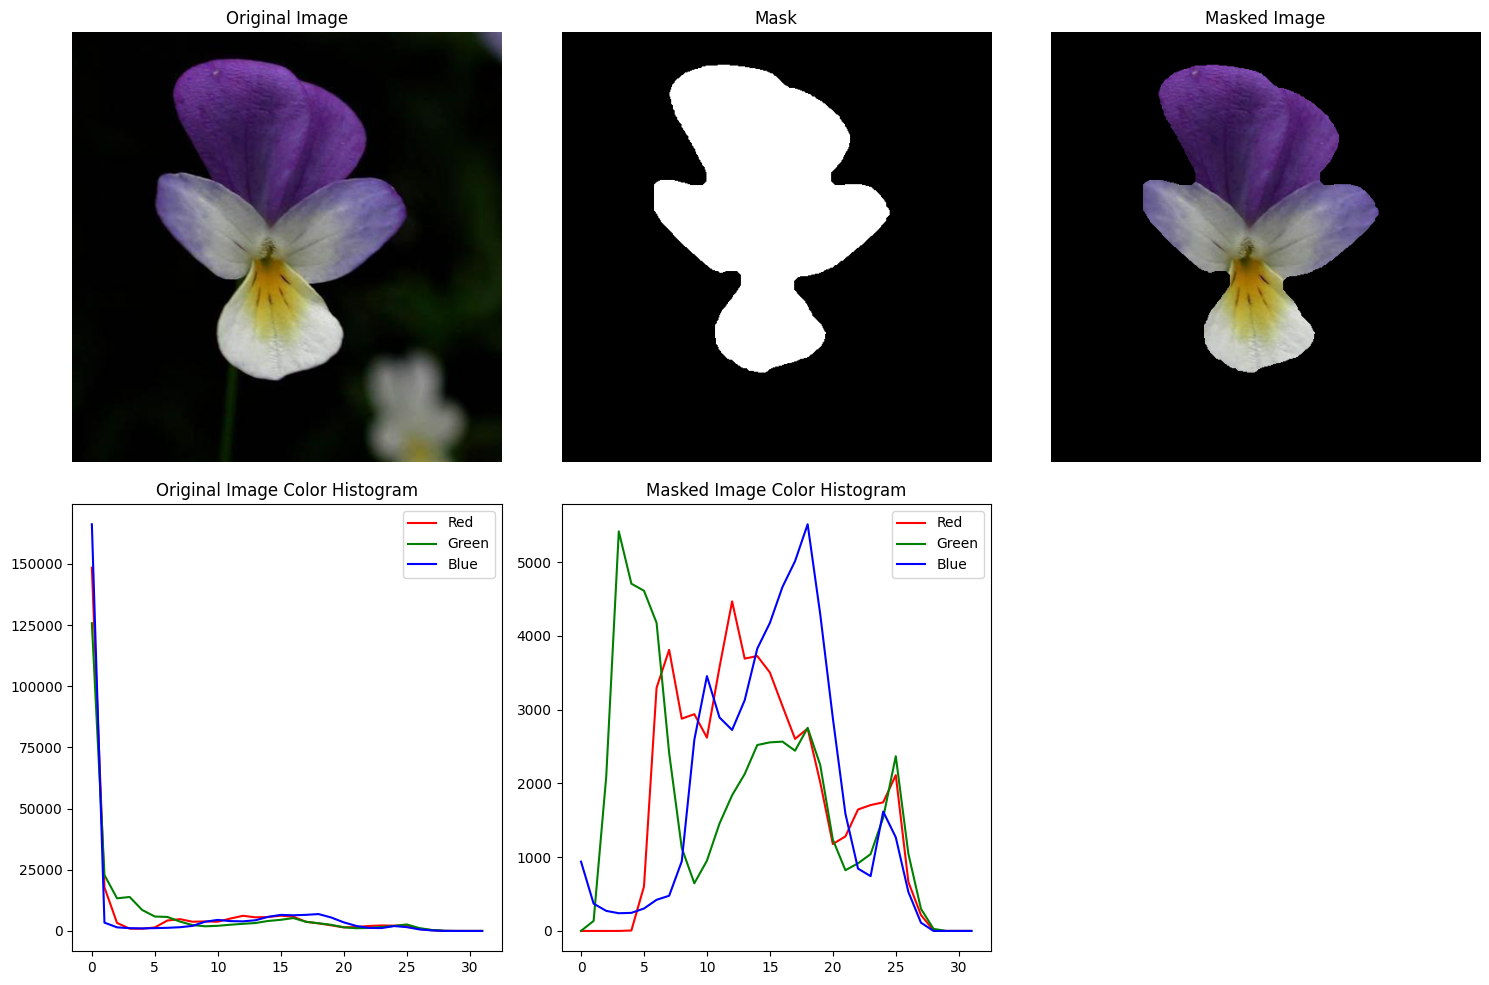

Feature vector shape: (96,)
This means we have 32 bins for each of the 3 color channels


In [ ]:
# Pick a sample image
sample_img_file = random.choice(os.listdir(IMAGES_PATH))
sample_mask_file = sample_img_file.replace("image", "mask")

# Load the image and mask
img_path = os.path.join(IMAGES_PATH, sample_img_file)
mask_path = os.path.join(MASKS_PATH, sample_mask_file)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Apply the mask
masked_img = img.copy()
for c in range(3):
    masked_img[:,:,c] = masked_img[:,:,c] * (mask / 255.0)

# Plot the images and histograms
plt.figure(figsize=(15, 10))

# Show the original image and masked image
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(masked_img)
plt.title('Masked Image')
plt.axis('off')

# Plot the histograms
color_names = ['Red', 'Green', 'Blue']
colors = ['r', 'g', 'b']

# Original image histograms
plt.subplot(2, 3, 4)
for i, col in enumerate(colors):
    hist = cv2.calcHist([img], [i], None, [32], [0, 256])
    plt.plot(hist, color=col, label=color_names[i])
plt.title('Original Image Color Histogram')
plt.legend()

# Masked image histograms
plt.subplot(2, 3, 5)
for i, col in enumerate(colors):
    hist = cv2.calcHist([masked_img], [i], mask, [32], [0, 256])
    plt.plot(hist, color=col, label=color_names[i])
plt.title('Masked Image Color Histogram')
plt.legend()

plt.tight_layout()
plt.show()

# Display the feature vector shape
bins = 32
hist_r = cv2.calcHist([masked_img], [0], mask, [bins], [0, 256]).flatten()
hist_g = cv2.calcHist([masked_img], [1], mask, [bins], [0, 256]).flatten()
hist_b = cv2.calcHist([masked_img], [2], mask, [bins], [0, 256]).flatten()

# Concatenate the histograms
hist_features = np.concatenate([hist_r, hist_g, hist_b])
print(f"Feature vector shape: {hist_features.shape}")
print(f"This means we have {bins} bins for each of the 3 color channels")

#MLP

:##Feature Extraction

For the MLP approach, I extracted a hybrid feature set combining color and texture information: 32-bin HSV color histograms (where hue represents the actual color independent of brightness and saturation) and GLCM texture features (capturing petal patterns and surface details). This complementary combination leverages both the distinctive color distributions of different flower species and their unique textural characteristics and than apply PCA with a component 40 .why 40? since i tested it on fetures extracted and for 40 pca component i got .94 so with 40 percent of data it get 0.94 feature and with such variance creating a robust feature representation that improves classification performance while maintaining a manageable feature dimensionality relative to our dataset size of 234 images.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import time
import cv2
import os
import random
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops
import gc
gc.collect()




print("Extracting color and texture features...")
bins = 32
std_size = (256, 256)

features = []
labels = []
filenames = []

for img_file in tqdm(os.listdir(IMAGES_PATH)):
    parts = img_file.split('_')
    if len(parts) >= 3:
        class_name = parts[1]
        try:
            img_path = os.path.join(IMAGES_PATH, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mask_file = img_file.replace("image", "mask")
            mask_path = os.path.join(MASKS_PATH, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img_resized = cv2.resize(img, std_size)
            mask_resized = cv2.resize(mask, std_size)

            masked_img = img_resized.copy()
            for c in range(3):
                masked_img[:,:,c] = masked_img[:,:,c] * (mask_resized / 255.0)

            hsv_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2HSV)

            h_hist = cv2.calcHist([hsv_img], [0], mask_resized, [bins], [0, 180])
            s_hist = cv2.calcHist([hsv_img], [1], mask_resized, [bins], [0, 256])
            v_hist = cv2.calcHist([hsv_img], [2], mask_resized, [bins], [0, 256])

            h_hist = cv2.normalize(h_hist, h_hist).flatten()
            s_hist = cv2.normalize(s_hist, s_hist).flatten()
            v_hist = cv2.normalize(v_hist, v_hist).flatten()

            color_moments = []
            for i in range(3):
                channel = hsv_img[:,:,i]
                channel_masked = channel[mask_resized > 0]
                if len(channel_masked) > 0:
                    mean = np.mean(channel_masked)
                    std = np.std(channel_masked)
                    skewness = np.mean(((channel_masked - mean) / (std + 1e-8)) ** 3) if std > 0 else 0
                    color_moments.extend([mean, std, skewness])
                else:
                    color_moments.extend([0, 0, 0])

            gray_masked = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

            glcm_features = []
            if np.count_nonzero(mask_resized) > 0:
                mask_indices = np.where(mask_resized > 0)
                if len(mask_indices[0]) > 0:
                    min_y, max_y = min(mask_indices[0]), max(mask_indices[0])
                    min_x, max_x = min(mask_indices[1]), max(mask_indices[1])

                    if min_y < max_y and min_x < max_x:
                        cropped_gray = gray_masked[min_y:max_y, min_x:max_x]

                        if cropped_gray.size > 0 and np.max(cropped_gray) > 0:
                            quant_gray = np.uint8(cropped_gray * (7.0/np.max(cropped_gray)))

                            if quant_gray.size > 100:
                                try:
                                    glcm = graycomatrix(quant_gray, distances=[1],
                                                      angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                      levels=8, symmetric=True, normed=True)

                                    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
                                        feature = graycoprops(glcm, prop).flatten()
                                        glcm_features.extend(feature)
                                except Exception as e:
                                    glcm_features = [0] * 20
                            else:
                                glcm_features = [0] * 20
                        else:
                            glcm_features = [0] * 20
                    else:
                        glcm_features = [0] * 20
                else:
                    glcm_features = [0] * 20
            else:
                glcm_features = [0] * 20

            # Combine features
            color_hist_features = np.concatenate([h_hist, s_hist, v_hist])
            feature_vector = np.concatenate([color_hist_features, color_moments, glcm_features])

            features.append(feature_vector)
            labels.append(class_name)
            filenames.append(img_file)

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

features = np.array(features)
labels = np.array(labels)
filenames = np.array(filenames)

print(f"Features extracted: {len(features)}")
print(f"Feature vector shape: {features.shape}")
print(f"Number of classes: {len(np.unique(labels))}")
print(f"Features per image: {features.shape[1]} ({bins*3} color histogram + 9 color moments + 20 texture)")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

n_components = 40
print(f"\nApplying PCA with {n_components} components...")
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_scaled)

print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Reduced feature shape: {features_pca.shape}")

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
class_names = label_encoder.classes_
print(f"Class names: {class_names}")

X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    features_pca, labels_encoded, filenames,
    test_size=0.2, random_state=42, stratify=labels_encoded
)

y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)


Extracting color and texture features...


100%|██████████| 234/234 [00:05<00:00, 39.25it/s]

Features extracted: 234
Feature vector shape: (234, 125)
Number of classes: 4
Features per image: 125 (96 color histogram + 9 color moments + 20 texture)

Applying PCA with 40 components...
Explained variance ratio: 0.9457
Reduced feature shape: (234, 40)
Class names: ['crocus' 'daisy' 'pansy' 'sunflower']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 64)                  │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,748 (22.45 KB)

 Trainable params: 5,524 (21.58 KB)

 Non-trainable params: 224 (896.00 B)


Training model with 40 PCA components...
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.2183 - loss: 2.0754 - val_accuracy: 0.1053 - val_loss: 1.7263 - learning_rate: 5.0000e-04
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2378 - loss: 2.1293 - val_accuracy: 0.1316 - val_loss: 1.6525 - learning_rate: 5.0000e-04
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2477 - loss: 2.0069 - val_accuracy: 0.1316 - val_loss: 1.5808 - learning_rate: 5.0000e-04
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3316 - loss: 1.6896 - val_accuracy: 0.1842 - val_loss: 1.5259 - learning_rate: 5.0000e-04
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3428 - loss: 1.6085 - val_accuracy: 0.2632 - val_loss: 1.4757 - learning_rate: 5.0000e-04
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3032 - loss: 1.7488 - val_accuracy: 0.3421 - val_loss: 1.4404 - learning_rate: 5.0000e-04
Epoch 7/100
10/10 ━━━━━

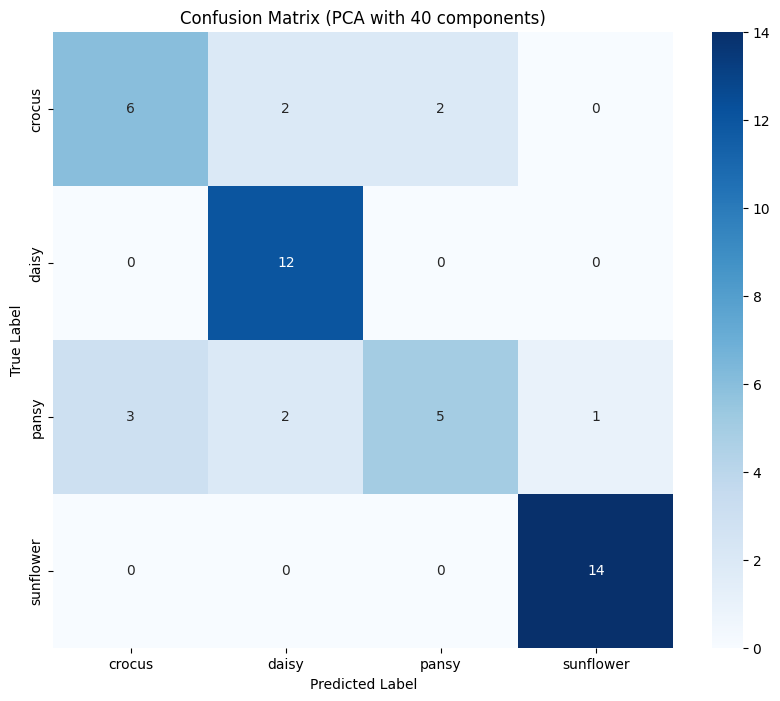

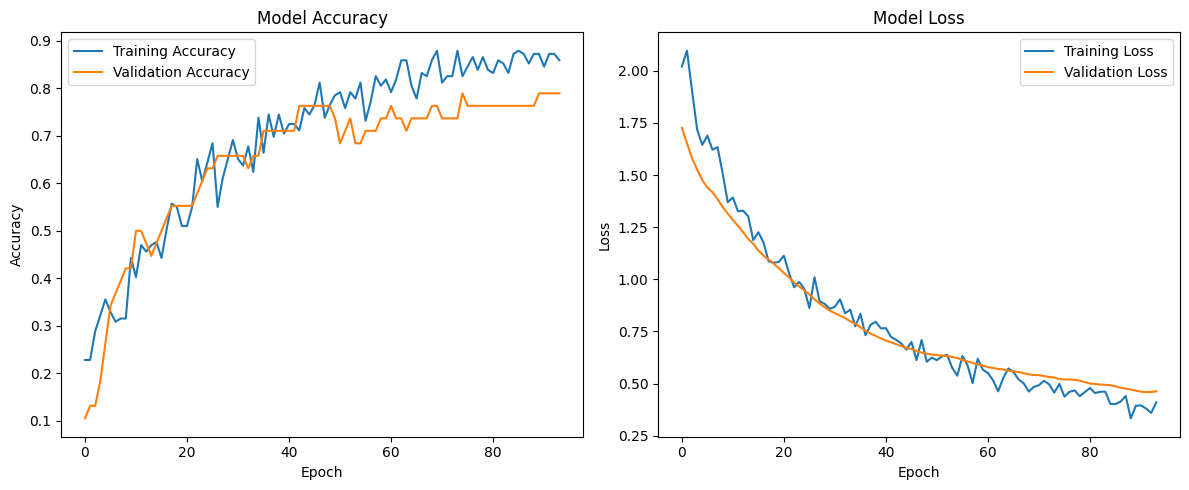

In [ ]:

def create_mlp_model(input_shape, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

np.random.seed(42)
tf.random.set_seed(42)

model = create_mlp_model(X_train.shape[1], len(np.unique(y_train)))
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)


print(f"\nTraining model with {n_components} PCA components...")
history = model.fit(
    X_train, y_train_onehot,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f}")
model.save('model_mlp.keras')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (PCA with {n_components} components)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


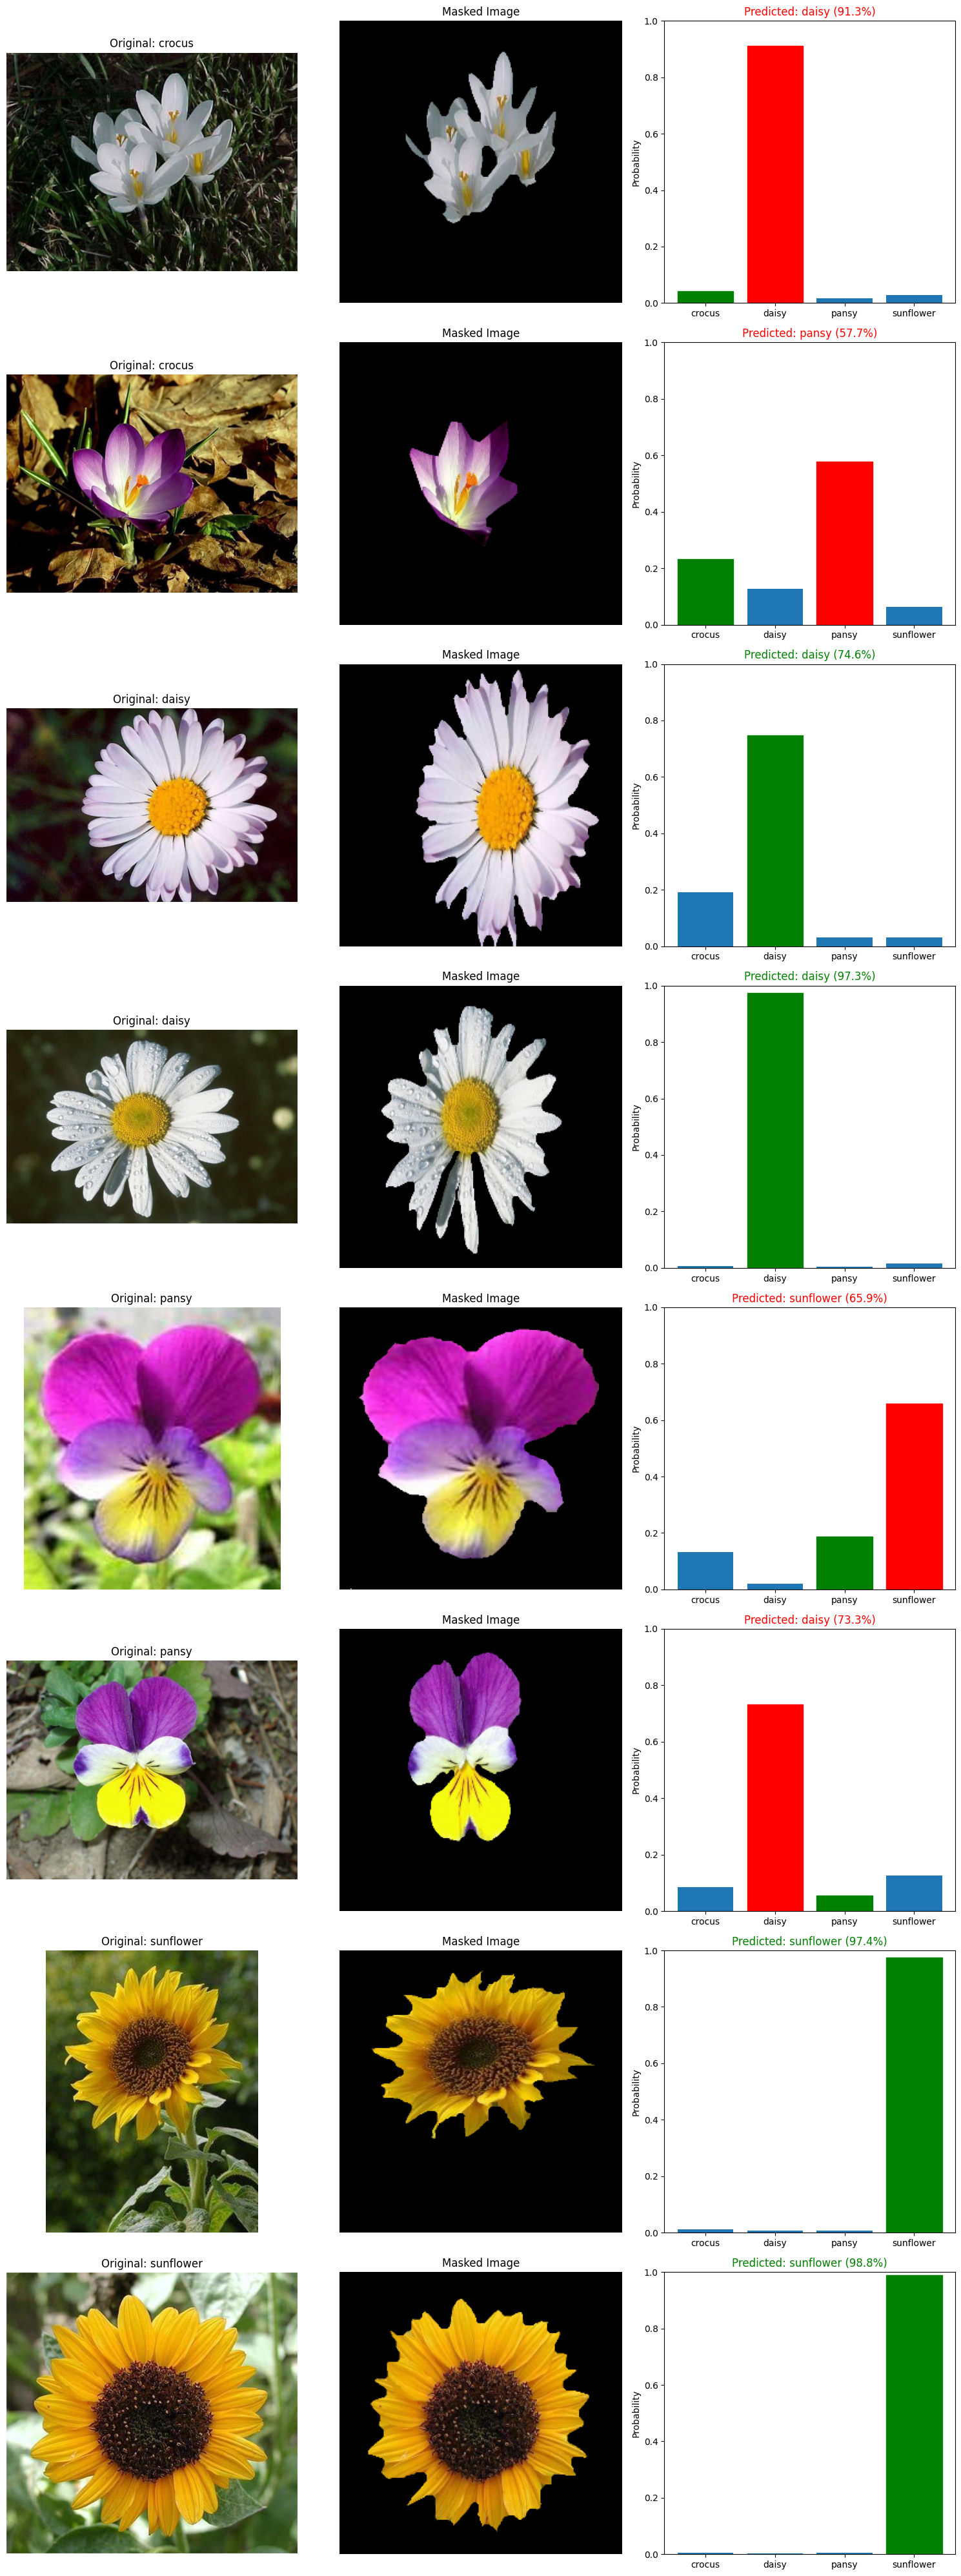


Test Images Results:
1. image_crocus_0037.png - True class: crocus
2. image_crocus_0034.png - True class: crocus
3. image_daisy_0133.png - True class: daisy
4. image_daisy_0161.png - True class: daisy
5. image_pansy_0219.png - True class: pansy
6. image_pansy_0227.png - True class: pansy
7. image_sunflower_0087.png - True class: sunflower
8. image_sunflower_0060.png - True class: sunflower


In [ ]:
def extract_features_from_image(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(img, std_size)
    mask_resized = cv2.resize(mask, std_size)

    masked_img = img_resized.copy()
    for c in range(3):
        masked_img[:,:,c] = masked_img[:,:,c] * (mask_resized / 255.0)

    hsv_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2HSV)

    h_hist = cv2.calcHist([hsv_img], [0], mask_resized, [bins], [0, 180])
    s_hist = cv2.calcHist([hsv_img], [1], mask_resized, [bins], [0, 256])
    v_hist = cv2.calcHist([hsv_img], [2], mask_resized, [bins], [0, 256])

    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()

    color_moments = []
    for i in range(3):
        channel = hsv_img[:,:,i]
        channel_masked = channel[mask_resized > 0]
        if len(channel_masked) > 0:
            mean = np.mean(channel_masked)
            std = np.std(channel_masked)
            skewness = np.mean(((channel_masked - mean) / (std + 1e-8)) ** 3) if std > 0 else 0
            color_moments.extend([mean, std, skewness])
        else:
            color_moments.extend([0, 0, 0])

    gray_masked = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

    glcm_features = []
    if np.count_nonzero(mask_resized) > 0:
        mask_indices = np.where(mask_resized > 0)
        if len(mask_indices[0]) > 0:
            min_y, max_y = min(mask_indices[0]), max(mask_indices[0])
            min_x, max_x = min(mask_indices[1]), max(mask_indices[1])

            if min_y < max_y and min_x < max_x:
                cropped_gray = gray_masked[min_y:max_y, min_x:max_x]

                if cropped_gray.size > 0 and np.max(cropped_gray) > 0:
                    quant_gray = np.uint8(cropped_gray * (7.0/np.max(cropped_gray)))

                    if quant_gray.size > 100:
                        try:
                            glcm = graycomatrix(quant_gray, distances=[1],
                                              angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                              levels=8, symmetric=True, normed=True)

                            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
                                feature = graycoprops(glcm, prop).flatten()
                                glcm_features.extend(feature)
                        except Exception as e:
                            glcm_features = [0] * 20
                    else:
                        glcm_features = [0] * 20
                else:
                    glcm_features = [0] * 20
            else:
                glcm_features = [0] * 20
        else:
            glcm_features = [0] * 20
    else:
        glcm_features = [0] * 20

    color_hist_features = np.concatenate([h_hist, s_hist, v_hist])
    feature_vector = np.concatenate([color_hist_features, color_moments, glcm_features])

    return feature_vector, img, masked_img

test_images = []
for class_name in class_names:
    class_files = [f for f in os.listdir(IMAGES_PATH)
                   if f.split('_')[1] == class_name and f not in filenames_train]
    if len(class_files) >= 2:
        selected_files = random.sample(class_files, 2)
        test_images.extend(selected_files)
    else:
        test_images.extend(class_files)
num_test_images = len(test_images)
fig, axes = plt.subplots(num_test_images, 3, figsize=(15, 5*num_test_images))

for i, img_file in enumerate(test_images):
    class_name = img_file.split('_')[1]
    img_path = os.path.join(IMAGES_PATH, img_file)
    mask_file = img_file.replace("image", "mask")
    mask_path = os.path.join(MASKS_PATH, mask_file)

    feature_vector, orig_img, masked_img = extract_features_from_image(img_path, mask_path)

    feature_vector_scaled = scaler.transform(feature_vector.reshape(1, -1))

    feature_vector_pca = pca.transform(feature_vector_scaled)

    prediction = model.predict(feature_vector_pca)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx] * 100

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f'Original: {class_name}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masked_img)
    axes[i, 1].set_title('Masked Image')
    axes[i, 1].axis('off')

    bars = axes[i, 2].bar(class_names, prediction[0])

    for j, bar in enumerate(bars):
        if class_names[j] == class_name:
            bar.set_color('green')
        elif class_names[j] == predicted_class and predicted_class != class_name:
            bar.set_color('red')

    result_color = 'green' if predicted_class == class_name else 'red'
    axes[i, 2].set_title(f'Predicted: {predicted_class} ({confidence:.1f}%)', color=result_color)
    axes[i, 2].set_ylim([0, 1])
    axes[i, 2].set_ylabel('Probability')

plt.tight_layout()
plt.show()

print("\nTest Images Results:")
for i, img_file in enumerate(test_images):
    class_name = img_file.split('_')[1]
    print(f"{i+1}. {img_file} - True class: {class_name}")

## HyperTuning Performed
- **Architecture**: Tested multiple depths (2-4 layers) and widths (64→32, 128→64→32→16)
- **PCA Components**: Tested 10, 20, 30, 40, 50 components (40 optimal)
- **Feature Extraction**:
  - Color histogram bins: 15 vs 32 (both effective)
  - Combined feature types: HSV histograms + color moments + GLCM texture
- **Regularization**:
  - Dropout rates: 0.25, 0.3, 0.5
  - L2 regularization: 0.001
- **Learning Rate**: Tested 0.001, 0.0005
- **Batch Size**: 16 provided better convergence than 32
- **Optimizer**: Adam with learning rate scheduler

#CNN



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import time
from tqdm import tqdm
import seaborn as sns

physical_devices = tf.config.list_physical_devices('GPU')

DATASET_PATH = '/content/dataset/'
IMAGES_PATH = os.path.join(DATASET_PATH, 'images')
IMG_SIZE = (256, 256)

images = []
labels = []
filenames = []

print("Loading images for CNN...")
for img_file in tqdm(os.listdir(IMAGES_PATH)):
    parts = img_file.split('_')
    if len(parts) >= 3:
        class_name = parts[1]

        img_path = os.path.join(IMAGES_PATH, img_file)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, IMG_SIZE)

            images.append(img_resized)
            labels.append(class_name)
            filenames.append(img_file)
        except Exception as e:
            continue

images = np.array(images, dtype=np.float32) / 255.0
labels = np.array(labels)
filenames = np.array(filenames)

print(f"Loaded {len(images)} images")
print(f"Number of classes: {len(np.unique(labels))}")

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
class_names = label_encoder.classes_
num_classes = len(class_names)
print(f"Classes: {class_names}")


Loading images for CNN...


100%|██████████| 234/234 [00:02<00:00, 114.20it/s]


Loaded 234 images
Number of classes: 4
Classes: ['crocus' 'daisy' 'pansy' 'sunflower']


In [ ]:
#Splitting
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, filenames_train_cnn, filenames_test_cnn = train_test_split(
    images, labels_encoded, filenames, test_size=0.2, random_state=42, stratify=labels_encoded
)

y_train_cnn_categorical = to_categorical(y_train_cnn, num_classes=num_classes)
y_test_cnn_categorical = to_categorical(y_test_cnn, num_classes=num_classes)

print(f"Training set: {X_train_cnn.shape[0]} images")
print(f"Testing set: {X_test_cnn.shape[0]} images")


Training set: 187 images
Testing set: 47 images


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 999ms/step - accuracy: 0.3193 - loss: 2.8958 - val_accuracy: 0.3617 - val_loss: 1.2018 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3750 - loss: 1.2889 - val_accuracy: 0.4894 - val_loss: 1.1436 - learning_rate: 0.0010
Epoch 3/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.4941 - loss: 1.0878 - val_accuracy: 0.5957 - val_loss: 0.7568 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5312 - loss: 1.0174 - val_accuracy: 0.7872 - val_loss: 0.7060 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step - accuracy: 0.5879 - loss: 0.8786 - val_accuracy: 0.8723 - val_loss: 0.6300 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5312 - loss: 0.8877 - val_accuracy: 0.8936 - val_loss: 0.5567 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.7783 - loss: 0.6702 - val_accuracy: 0.8298 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8125 - loss: 0.5232 - val_accuracy: 0.8723 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 561ms/step - accuracy: 0.7365 - loss: 0.6366 - val_accuracy: 0.9362 -

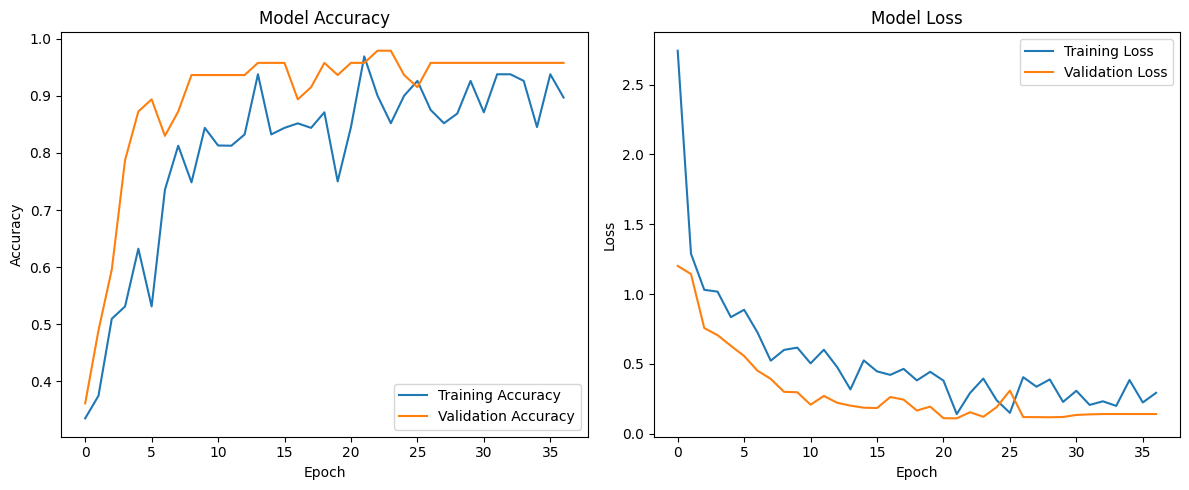

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


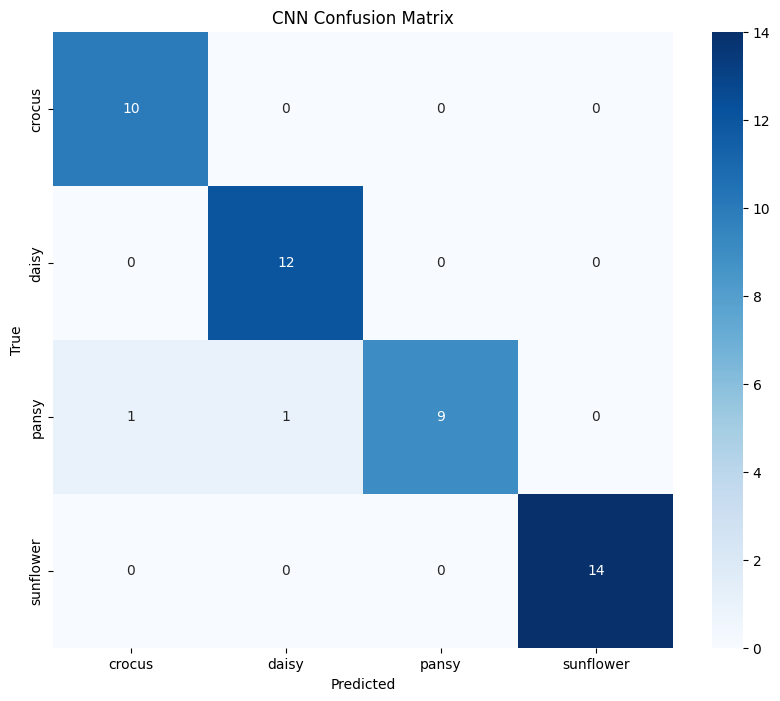


CNN Classification Report:
              precision    recall  f1-score   support

      crocus       0.91      1.00      0.95        10
       daisy       0.92      1.00      0.96        12
       pansy       1.00      0.82      0.90        11
   sunflower       1.00      1.00      1.00        14

    accuracy                           0.96        47
   macro avg       0.96      0.95      0.95        47
weighted avg       0.96      0.96      0.96        47



In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
start_time = time.time()

history_cnn = model_cnn.fit(
    datagen.flow(X_train_cnn, y_train_cnn_categorical, batch_size=32),
    steps_per_epoch=len(X_train_cnn) // 32,
    epochs=100,
    validation_data=(X_test_cnn, y_test_cnn_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

cnn_training_time = time.time() - start_time
print(f"Training time: {cnn_training_time:.2f} seconds")

start_time = time.time()
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn_categorical, verbose=0)
cnn_inference_time = time.time() - start_time

print(f"Test accuracy: {test_acc_cnn:.4f}")
print(f"Inference time: {cnn_inference_time:.4f} seconds")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_cnn, y_pred_classes_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nCNN Classification Report:")
print(classification_report(y_test_cnn, y_pred_classes_cnn, target_names=class_names))

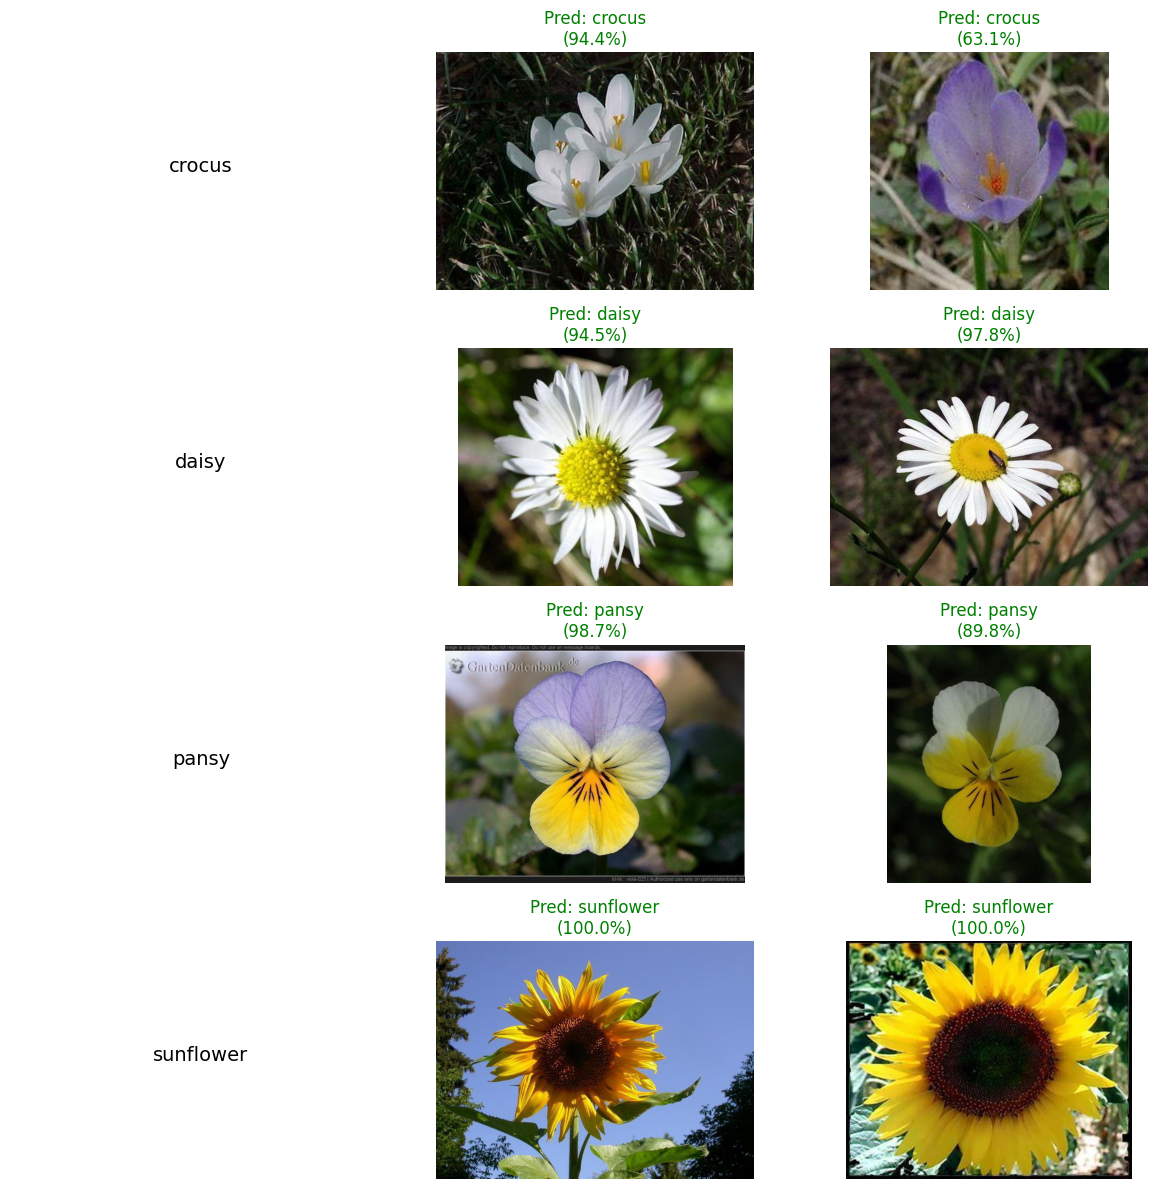

In [ ]:
# Test on individual images
def test_on_images():
    # Create a dictionary to store sample images for each class
    test_images = {}

    # Find 2 test images for each class
    for class_name in class_names:
        # Get all images of this class
        class_files = [f for f in os.listdir(IMAGES_PATH)
                      if f.split('_')[1] == class_name and f not in filenames_train]

        # Take 2 random samples
        if len(class_files) >= 2:
            samples = random.sample(class_files, 2)
            test_images[class_name] = samples
        else:
            test_images[class_name] = class_files

    # Create figure
    num_classes = len(test_images)
    samples_per_class = 2
    fig, axes = plt.subplots(num_classes, samples_per_class + 1, figsize=(12, 3*num_classes))

    # Process each class
    for i, (class_name, img_files) in enumerate(test_images.items()):
        # Show class name
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=14, ha='center')
        axes[i, 0].axis('off')

        # Process each image in this class
        for j, img_file in enumerate(img_files[:samples_per_class]):
            # Load and process image
            img_path = os.path.join(IMAGES_PATH, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Display original image
            axes[i, j+1].imshow(img)

            # Prepare image for prediction
            img_resized = cv2.resize(img, IMG_SIZE)
            img_array = np.expand_dims(img_resized / 255.0, axis=0)

            # Make prediction
            prediction = model_cnn.predict(img_array, verbose=0)
            pred_class_idx = np.argmax(prediction[0])
            pred_class = class_names[pred_class_idx]
            confidence = prediction[0][pred_class_idx] * 100

            # Set title color based on prediction
            title_color = 'green' if pred_class == class_name else 'red'
            axes[i, j+1].set_title(f"Pred: {pred_class}\n({confidence:.1f}%)", color=title_color)
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

# Add this to ensure we have the random module
import random

# Run the test
test_on_images()

#Comparing 2 Different Approches

In [ ]:
# Initialize comparison dictionary
comparison = {
    'Model': ['MLP (with PCA)', 'CNN (raw images)'],
    'Test Accuracy': [0, 0],
    'Inference Time (s)': [0, 0],
    'Model Parameters': [0, 0]
}

# MLP predictions and accuracy
mlp_test_pred = model.predict(X_test)
mlp_test_pred_classes = np.argmax(mlp_test_pred, axis=1)
mlp_accuracy = accuracy_score(y_test, mlp_test_pred_classes)

# CNN predictions and accuracy
cnn_test_pred = model_cnn.predict(X_test_cnn)
cnn_test_pred_classes = np.argmax(cnn_test_pred, axis=1)
cnn_accuracy = accuracy_score(y_test_cnn, cnn_test_pred_classes)

# Measure inference times
start_time = time.time()
_ = model.predict(X_test)
mlp_inference_time = time.time() - start_time

start_time = time.time()
_ = model_cnn.predict(X_test_cnn)
cnn_inference_time = time.time() - start_time

# Count model parameters
mlp_params = model.count_params()
cnn_params = model_cnn.count_params()

# Update comparison dictionary
comparison['Test Accuracy'] = [mlp_accuracy, cnn_accuracy]
comparison['Inference Time (s)'] = [mlp_inference_time, cnn_inference_time]
comparison['Model Parameters'] = [mlp_params, cnn_params]

# Create DataFrame and display results
df = pd.DataFrame(comparison)
print("Model Comparison:")
print(df)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Model Comparison:
              Model  Test Accuracy  Inference Time (s)  Model Parameters
0    MLP (with PCA)       0.787234            0.137858              5748
1  CNN (raw images)       0.957447            0.323263          14839492


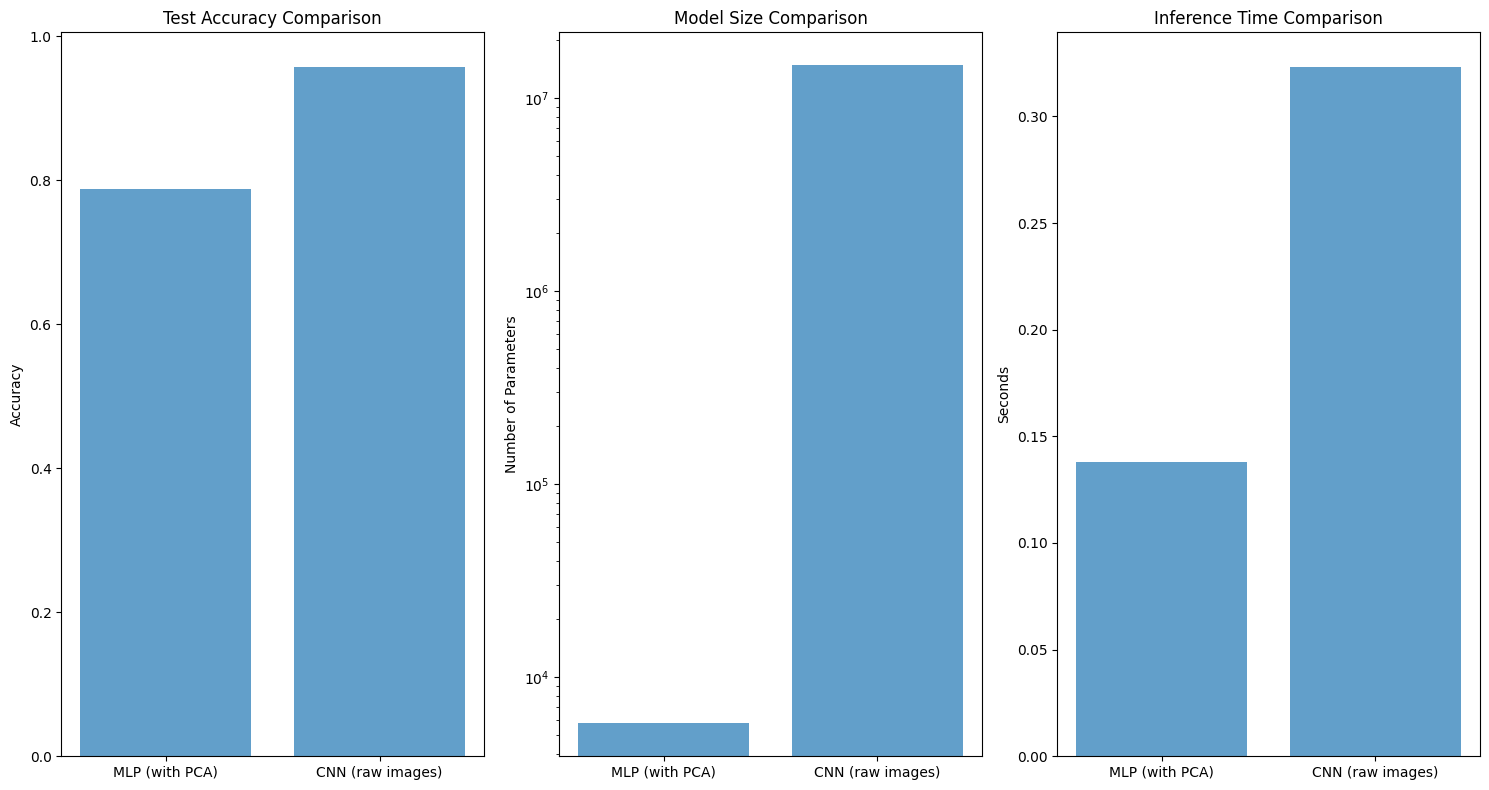

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
models = comparison['Model']
y_pos = np.arange(len(models))

plt.bar(y_pos, comparison['Test Accuracy'], align='center', alpha=0.7)
plt.xticks(y_pos, models)
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')

plt.subplot(1, 3, 2)
plt.bar(y_pos, comparison['Model Parameters'], align='center', alpha=0.7)
plt.xticks(y_pos, models)
plt.ylabel('Number of Parameters')
plt.title('Model Size Comparison')
plt.yscale('log')

plt.subplot(1, 3, 3)
plt.bar(y_pos, comparison['Inference Time (s)'], align='center', alpha=0.7)
plt.xticks(y_pos, models)
plt.ylabel('Seconds')
plt.title('Inference Time Comparison')

plt.tight_layout()
plt.show()


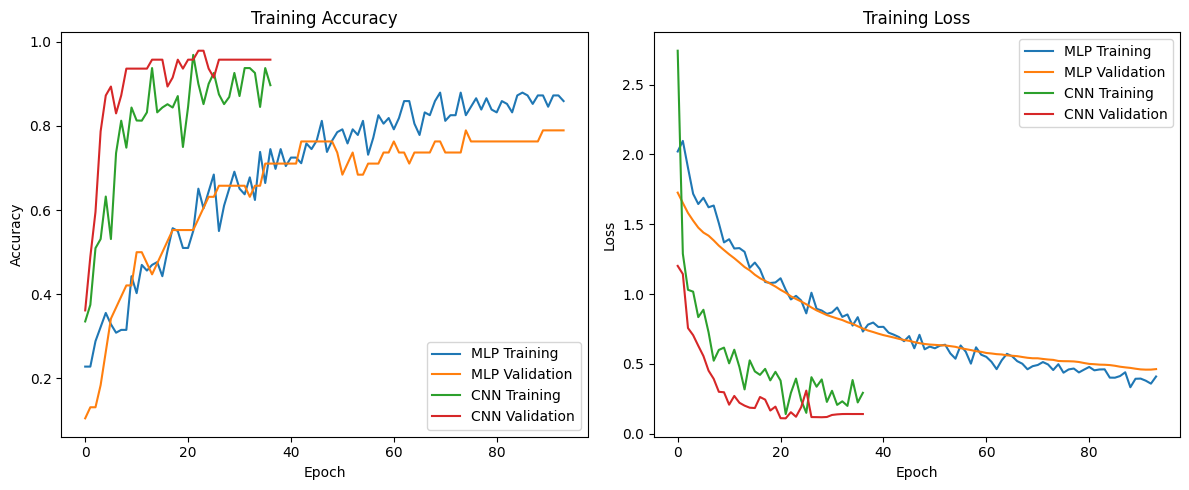

In [ ]:
# Compare training histories
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='MLP Training')
plt.plot(history.history['val_accuracy'], label='MLP Validation')
plt.plot(history_cnn.history['accuracy'], label='CNN Training')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='MLP Training')
plt.plot(history.history['val_loss'], label='MLP Validation')
plt.plot(history_cnn.history['loss'], label='CNN Training')
plt.plot(history_cnn.history['val_loss'], label='CNN Validation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

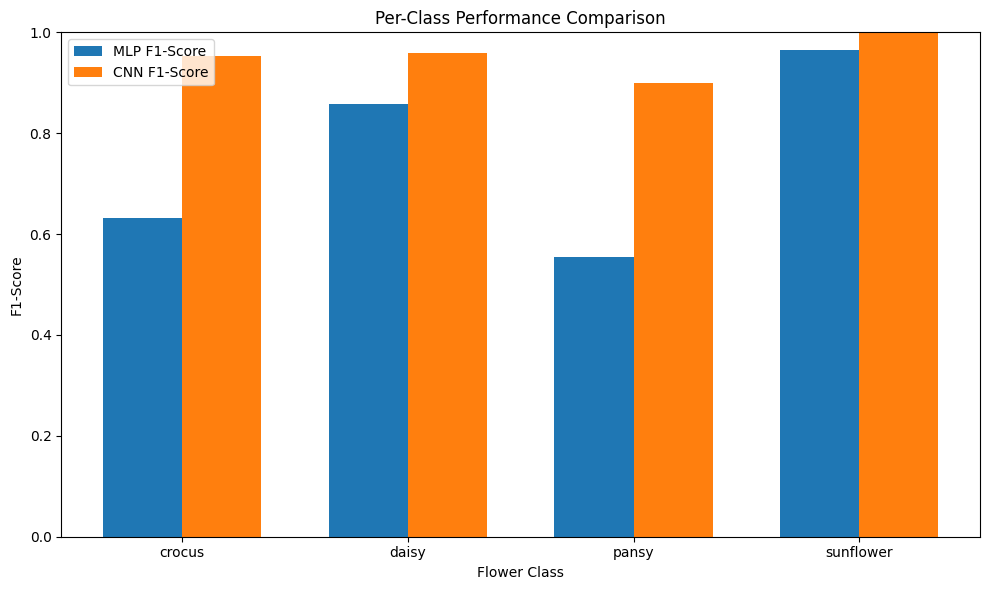

In [ ]:
mlp_report = classification_report(y_test, mlp_test_pred_classes,
                                 target_names=class_names, output_dict=True)
cnn_report = classification_report(y_test_cnn, cnn_test_pred_classes,
                                 target_names=class_names, output_dict=True)

classes = []
mlp_class_acc = []
cnn_class_acc = []

for cls in class_names:
    classes.append(cls)
    mlp_class_acc.append(mlp_report[cls]['f1-score'])
    cnn_class_acc.append(cnn_report[cls]['f1-score'])

plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, mlp_class_acc, width, label='MLP F1-Score')
plt.bar(x + width/2, cnn_class_acc, width, label='CNN F1-Score')

plt.xlabel('Flower Class')
plt.ylabel('F1-Score')
plt.title('Per-Class Performance Comparison')
plt.xticks(x, classes)
plt.legend()
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

# Store results in a variable if needed
results = df

# Hyperparameter Tuning

## MLP Model (with feature extraction and PCA)
- **Architecture**: Tested multiple depths (2-4 layers) and widths (64→32, 128→64→32→16)
- **PCA Components**: Tested 10, 20, 30, 40, 50 components (40 optimal)
- **Feature Extraction**:
  - Color histogram bins: 15 vs 32 (both effective)
  - Combined feature types: HSV histograms + color moments + GLCM texture
- **Regularization**:
  - Dropout rates: 0.25, 0.3, 0.5
  - L2 regularization: 0.001
- **Learning Rate**: Tested 0.001, 0.0005
- **Batch Size**: 16 provided better convergence than 32
- **Optimizer**: Adam with learning rate scheduler

## CNN Model (with raw images)
- **Architecture**: Tested various configurations (3-layer vs 4-layer)
- **Input Size**: 64×64 vs 256×256 resolution
- **Filter Numbers**: 32→64→128 configuration
- **Data Augmentation**: Rotation, width/height shift, horizontal flip, zoom
- **Regularization**: Dropout 0.5 after dense layer, 0.25 after conv layers
- **Learning Rate**: 0.001 with ReduceLROnPlateau
- **Loss Function**: Categorical crossentropy vs sparse categorical crossentropy
- **Batch Size**: 32 optimal for CNN
- **Early Stopping**: Patience of 15 epochs

# 5. Conclusions

This study compared two deep learning approaches for flower classification: an MLP using explicit feature extraction and a CNN with automatic feature learning. The experimental results demonstrated that the CNN achieved superior accuracy (95.74% vs 78.72%) and consistently better F1-scores across all flower classes, particularly for crocus and pansy categories. However, this performance advantage came with significantly higher computational costs, as evidenced by the CNN's larger parameter count (14.8M vs 5.7K) and slower inference time (0.323s vs 0.138s). The CNN's training process also exhibited faster convergence and more stable validation metrics, highlighting its superior feature representation capabilities. The MLP with PCA-reduced features (40 components) offered a reasonable compromise between performance and efficiency, though it couldn't match the CNN's ability to capture complex spatial relationships within the images. These findings confirm that while CNNs are generally more effective for image classification tasks, MLPs with carefully engineered features present a viable alternative for resource-constrained scenarios where computational efficiency takes precedence over maximum classification accuracy.